# CNR reconstructions of MCF10A parental and PI3K mutant cells

## Background & summary

In this notebook, we perform Comparative Network Reconstruction (CNR) on MCF10A parental en PI3K mutant cells.
This is based on perturbation data of single inhibitors at 2 concentrations (~IC50 and IC90), and selected combinations.
Network reconstructions will be done based mainly on a known topology, although we do explore the effect of additional edges. 

To select how many and which edges should be added, we perform leave-one-out cross-validation (loocv).
The loocv will only be done on the drug combinations (but in the networks reconstructions the single drug data is included).
This is because when leaving out (high-concentration) single drug samples, we don't get estimates for the direct perturbation effect, which we need to predict the response of the held-out sample.
Only edges that are recurrently added in loocv solutions with hyper-parameter settings that lead to good performance are retained.

##  Data and model preparation

Input data:

  * Remove uninformative Treatments and Epitopes (Akt1 and GSKi)
  * Rename columns to be consistent with Envision data

In [1]:
import pandas as pd
import cnr
import cnr.cnrplot
import scipy.optimize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import cplex
import re
import sympy
import random
import statsmodels.stats.multitest
import itertools
import statistics

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Set plotting defaults
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
# rcParams['mathtext.rm'] = 'Palatino'

# Fix some font issues
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size= BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


In [2]:
wt = pd.read_csv("../results/perturbations/wt-luminex-lfc.tsv",
                 sep="\t", index_col=0)
pi3k = pd.read_csv("../results/perturbations/pi3k-luminex-lfc.tsv",
                   sep="\t", index_col=0)


# Remove uninformative Treatements and Epitopes
wt.index.name = None
pi3k.index.name = None
wt = wt.drop("Akt1").drop(['FGFRi 0.1uM'], axis=1)
pi3k = pi3k.drop("Akt1").drop(['FGFRi 0.1uM'], axis=1)
# wt = wt.drop("Akt1").drop(['FGFRi 0.1uM', 'GSK3i 2uM', 'GSK3i 5uM'], axis=1)
# pi3k = pi3k.drop("Akt1").drop(['FGFRi 0.1uM', 'GSK3i 2uM', 'GSK3i 5uM'], axis=1)

# Rename columns


def clean_colname(s):
    return s.replace(" ", "").replace(".", "").replace("+", "_")


wt.columns = [clean_colname(s) for s in list(wt.columns)]
pi3k.columns = [clean_colname(s) for s in list(pi3k.columns)]

col_dict = {"wt": "#984EA3", "pi3k": "#4DAF4A"}

COMBO_NAMES = [c for c in wt.columns if len(c.split("_")) > 1]
rglob_measured = {"wt":wt[COMBO_NAMES], "pi3k": pi3k[COMBO_NAMES]}

# Parameters mapping of signaling to viability
df_mapping = pd.read_csv(
    '../results/perturbations/signaling-viability-parameters.tsv', 
    sep='\t', index_col=0
)
df_mapping


#KM_ERK_WT = df_mapping['estimate']["WT"]
# KM_AKT = df_mapping['estimate']["KM_BioAkt"]
KM_ERK_WT = df_mapping[df_mapping.term == "KM_ERK1"]["estimate"]["WT"]
KM_ERK_PI3K = df_mapping[df_mapping.term == "KM_ERK1"]["estimate"]["PI3K"]
KM_AKT_WT = df_mapping[df_mapping.term == "KM_BioAkt"]["estimate"]["WT"]
KM_AKT_PI3K = df_mapping[df_mapping.term == "KM_BioAkt"]["estimate"]["PI3K"]

Annotations required for CNR:

  * List of node names (NODES)
  * List of annotations for the perturbations (PERTURBATIONS)
  * Dict of perturabtion target annotations (PERTS_ANNOT)
  * List of inhibitors that act downstream of their direct target (DOWNSTREAM_ACTING_INHIBITORS)
  * List of known interactions (GIVEN_EDGES)
  * Upper/lower bounds on the parameter values. We use 1.5x of the highest response (BOUNDS, optional).
  
 These are defined in the file model.py

In [3]:
from model import *

print("NODES:\n", NODES)

print("\nPERTURBATIONS:\n", PERTURBATIONS)

print("\nPERTS_ANNOT:\n", PERTS_ANNOT)

print("\nDOWNSTREAM_ACTING_INHIBITORS:\n", DOWNSTREAM_ACTING_INHIBITORS)

print("\nGIVEN_EDGES:\n", GIVEN_EDGES)

print("\nINHIB_TARGET_PAIRS:\n", INHIB_TARGET_PAIRS)

# Restrict parameter values to maximally 1.5x the highest overall measured response
BOUNDS = 1.5*max(wt.abs().max().max(), pi3k.abs().max().max())

NODES:
 ('EGFR', 'MEK1', 'ERK1', 'GSK3', 'CREB1', 'BioAkt', 'PRAS40', 'P70S6K', 'RS6')

PERTURBATIONS:
 [['IGF1Ri3uMmek', 'IGF1Ri3uMakt'], ['IGF1Ri10uMmek', 'IGF1Ri10uMakt'], ['EGFRi03uM'], ['EGFRi1uM'], ['RAFi1uM'], ['MEKi0002uM', 'MEKi0002uMds'], ['MEKi002uM', 'MEKi002uMds'], ['ERKi002uM'], ['ERKi04uM'], ['GSK3i2uM'], ['GSK3i5uM'], ['PI3Ki1uM'], ['PI3Ki2uM'], ['AKTi1uM'], ['AKTi5uM'], ['mTORi001uMmtorc1', 'mTORi001uMmtorc2'], ['mTORi03uMmtorc1', 'mTORi03uMmtorc2'], ['EGFRi03uM', 'IGF1Ri3uMmek', 'IGF1Ri3uMakt'], ['EGFRi03uM', 'MEKi0002uM', 'MEKi0002uMds'], ['EGFRi03uM', 'ERKi002uM'], ['MEKi0002uM', 'MEKi0002uMds', 'ERKi002uM'], ['IGF1Ri3uMmek', 'IGF1Ri3uMakt', 'AKTi1uM'], ['IGF1Ri3uMmek', 'IGF1Ri3uMakt', 'mTORi001uMmtorc1', 'mTORi001uMmtorc2'], ['PI3Ki1uM', 'mTORi001uMmtorc1', 'mTORi001uMmtorc2'], ['AKTi1uM', 'mTORi001uMmtorc1', 'mTORi001uMmtorc2'], ['EGFRi03uM', 'PI3Ki1uM'], ['EGFRi03uM', 'AKTi1uM'], ['EGFRi03uM', 'mTORi001uMmtorc1', 'mTORi001uMmtorc2'], ['MEKi0002uM', 'MEKi0002uMds'

What does the perturbation data look like?

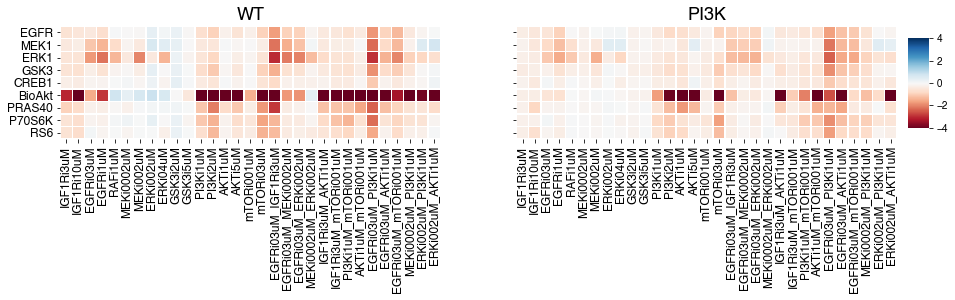

In [4]:
panel = cnr.PerturbationPanel(
    NODES, PERTURBATIONS, PERTS_ANNOT, DOWNSTREAM_ACTING_INHIBITORS, 
    rglob = {"WT":wt, "PI3K":pi3k}
)
cnr.cnrplot.heatmap_cnr(panel.rglob, annot = False, vmin=-4, vmax=4)

First, we need to define some helper functions to add constraints that are specific to this experimental setup, such as the fact that we have multiple doses per inhibitor).

  1. We assume that a higher inhibitor concentration has a stronger effect. We add this as constraints to the CNR problem. 
  2. The direct target-inhibition effect of an inhibitor is either the same for all dosages, or allowed to differ for all.

In [5]:
def get_concentration_from_pertname(pert_name):
    concentration = re.split(r"(\d+uM)", pert_name)[1].replace("uM", "")
    if concentration[0] == "0":
        concentration = "."+concentration[1:]
    return float(concentration)


def add_inhibitor_constraints(p, inhib_set):
    # Collect all inhibitor-target combinations
    rpvars = [var for var in p.cpx.variables.get_names(
    ) if var.startswith("rp_") or var.startswith("rpDS_")]

    # Generate a set of all inhibitor-target pairs
    inhib_targets = set()
    for inhib in list(inhib_set):
        targets = set([v.split("_")[3] for v in rpvars if inhib in v])
        for t in targets:
            inhib_targets.add((inhib, t))

    # Generate set of all matching perturbation names:
    # tuples of: Same inhibitor, same target, same cell-line, 
    # multiple concentrations.
    # Sort based on name --> lowest concentration first
    # Assume two concentrations per inhibitor-target pair
    perturbations_matched_sorted = set()
    for inhib, target in inhib_targets:
        varnames = [var for var in rpvars if inhib in var and target in var]
        for cl in p.cell_lines:
            psm = tuple(sorted([var for var in varnames if cl in var]))
            assert len(psm) == 2, psm
            if (get_concentration_from_pertname(psm[0]) < 
                get_concentration_from_pertname(psm[1])):
                perturbations_matched_sorted.add(psm)
            else:
                perturbations_matched_sorted.add(tuple(reversed(psm)))

    # Add the constraints:
    # p_low - p_high > 0
    # This assumes p_low and p_high are negative
    constraints = []
    for p_low, p_high in perturbations_matched_sorted:
        constraints.append(cplex.SparsePair(
            ind=[p_low, p_high], val=[1.0, -1.0]))
    p.cpx.linear_constraints.add(
        lin_expr=constraints,
        senses=['G']*len(constraints), rhs=[0.]*len(constraints)
    )
    
# Merge the indicators for each inhibor-target pair (multiple concentrations)
def select_indicators_to_merge(inhib, target, var_list):
    # Get the relevant variables
    rpvars = [var for var in var_list if 
                  var.startswith("rp")
                 and inhib in var.split("_")[2]
                 and var.split("_")[3] == target]
    # Match the variables to the indicators
    indicators = set()
    for rpvar in rpvars:
        rpvar = rpvar.split("_")
        indicators.update(["_".join(["I"+rpvar[0]+"Dev"] + rpvar[2:])])        
    return list(indicators)


# Merge the indicators for each inhibor-target pair (multiple concentrations)
def select_indicators_to_merge(inhib, target, var_list):
    # Get the relevant variables
    rpvars = [var for var in var_list if 
                  var.startswith("rp")
                 and inhib in var.split("_")[2]
                 and var.split("_")[3] == target]
    # Match the variables to the indicators
    indicators = set()
    for rpvar in rpvars:
        rpvar = rpvar.split("_")
        indicators.update(["_".join(["I"+rpvar[0]+"Dev"] + rpvar[2:])])        
    return list(indicators)

## Leave one out cross validation to select model complexity

We explore the model fitting by performing a leave-one-out cross-validation like analysis.
We will only leave out drug combination measurements, because we cannot make predictions about inhibitor-concentrations that are not included in the reconstruction.

To assess model performance, we'll look at:

  * the residuals of the reconstruction (which is what the method optimizes for)
  * the prediction error in the predicted viability.
  
We relate the ERK and AKT response to the viability through:
$$\text{viability} = 1/\left(1-\frac{\Delta ERK}{KM_{ERK}}-\frac{\Delta AKT}{KM_{AKT}}\right)$$

In another notebook we have estimated that $KM_{ERK}$ and $KM_{AKT}$ for both cell lines.

In [8]:
def loocv_train(test_col_idx, given_edges, eta, theta, bounds):
    """Train model leaving out the column test_col_idx
    
    Parameters:
    test_col_idx: name of column to leave out
    given_edges: list of tuple indicating which edges are included.
    eta, theta, bounds: floats
    
    returns a tuple (test_col_idx, sol)
    """
    # Get name of Rglob column to remove
    test_col_name = wt.columns[test_col_idx]

    # Remove perturbation
    pert_copy = PERTURBATIONS.copy()
    pert_copy.pop(test_col_idx)
    
    # Define the reduced perturbation panel
    train_panel = cnr.PerturbationPanel(
        NODES, pert_copy, PERTS_ANNOT, DOWNSTREAM_ACTING_INHIBITORS,        
        rglob = {"wt":wt.drop(test_col_name, axis=1), 
                 "pi3k":pi3k.drop(test_col_name, axis=1)}
    )
    
    # Define the CNR problem
    p = cnr.CnrProblem(train_panel, eta=eta, theta=theta, bounds=bounds)
    p.set_interactions_status(given_edges, 1)
    p.set_edge_sign(POSITIVE_EDGES, "pos")
    
    # All perturbation are negative
    p.set_pert_sign(
        [(p_name, p_target) for p_name, p_target in PERTS_ANNOT.items()
        if p_name not in DOWNSTREAM_ACTING_INHIBITORS], "neg")
    
    # Higher concentration have bigger effects
    # RAFi is only measured at a single concentration
    add_inhibitor_constraints(p, set(INHIBITORS)-{"RAFi"})

    # Merge the indicators corresponding to the same inihibitor
    for inhib, target in INHIB_TARGET_PAIRS:
        indicators_to_merge = select_indicators_to_merge(
            inhib, target, p.cpx.variables.get_names()
        )
        merged_indicator_name = "_".join(
            ["Imerged".split("_")[0], inhib, target])
        p.merge_indicators(indicators_to_merge, merged_indicator_name)

    p.cpx.solve()
    return (test_col_name, cnr.CnrResult(p))

def predict_combo(sol, combo):
    d = dict()
    for cl in ["wt", "pi3k"]:
        rpert = pd.DataFrame(index = sol.nodes)
        rpert[combo] = sol.rpert[cl][combo.split("_")].sum(axis = 1)
        rloc = sol.rloc[cl]
        mat =  -np.dot(np.linalg.inv(rloc), rpert)
        d[cl] = pd.DataFrame(mat, index = rpert.index, columns = rpert.columns)
    return d

def loocv_predict(loocv_sols):
    # Input is list of form combo-name (str), solution (CnrResult)
    prediction = {
        'wt':   pd.DataFrame(index = loocv_sols[0][1].nodes),
        'pi3k': pd.DataFrame(index = loocv_sols[0][1].nodes)
    }
    
    for combo, sol in loocv_sols:
        p = predict_combo(sol, combo)
        prediction['wt'][combo] = p['wt']
        prediction['pi3k'][combo] = p['pi3k']
    return prediction

def viability(ERK, AKT, CL):
    assert CL in ["wt", "pi3k"]
    if CL == "wt":
        KM_ERK = KM_ERK_WT
        KM_AKT = KM_AKT_WT
    elif CL == "pi3k":
        KM_ERK = KM_ERK_PI3K
        KM_AKT = KM_AKT_PI3K

    return (1/(1 -ERK/KM_ERK -AKT/KM_AKT))
    
def panel_predict_viability(prediction):
    v = dict()
    for cl, p in prediction.items():
        rglob = p.transpose()
        v[cl] = viability(rglob.ERK1, rglob.BioAkt, cl)
    return v


### Scan over hyper-parameters

We scan over eta and theta to select best parameters to use.
(Note: Running this scan takes some time, so we freeze these cells for now)

In [ ]:
%%capture
eta_vals = [0,  0.1, 0.5, 1, 2, 10, 100]
theta_vals = [0, 0.01, 0.05, 0.1, 0.25, 1, 100]
loocv_predictions = dict()
loocv_viabilities = dict()
loocv_solution = dict()
for eta in eta_vals:
    for theta in theta_vals:
        loocv_sols = [loocv_train(i, given_edges=GIVEN_EDGES, eta=eta,
                                  theta=theta, bounds=BOUNDS) 
                      for i in range(17, len(PERTURBATIONS))]
        loocv_solution[(eta, theta)] = loocv_sols
        loocv_prediction = loocv_predict(loocv_sols)
        loocv_predictions[(eta, theta)] = loocv_prediction
        loocv_viabilities[(eta, theta)] = panel_predict_viability(
            loocv_prediction)

In [ ]:
colnames = loocv_predictions[(0, 0)]['pi3k'].columns

KM_ERK_WT, KM_AKT_WT = df_mapping["estimate"].WT
KM_ERK_PI3K, KM_AKT_PI3K = df_mapping["estimate"].PI3K

error_viability = dict()
for param, viabilities in loocv_viabilities.items():
    error_viability[param] = dict()
    v_measure = panel_predict_viability(rglob_measured)
    for cl, v_predict in viabilities.items():
        error_viability[param][cl] = (v_predict - v_measure[cl]).pow(2).mean()

In [2]:
def get_mssr_from_loocv(loocv_sols):
    mssr = 0.
    n = 0
    for combo, sol in loocv_sols:
        for cl in ["wt", "pi3k"]:
            n += 1
            rpert = sol.rpert[cl][combo.split("_")].sum(axis=1)
            res = (np.dot(sol.rloc[cl], rglob_measured[cl]
                          [combo]) + rpert).pow(2).mean()
            mssr += res
    return mssr/n


loocv_mssr = {param: get_mssr_from_loocv(
    loocv_sols) for param, loocv_sols in loocv_solution.items()}

error = {"wt": pd.DataFrame(index = wt.index),
         "pi3k": pd.DataFrame(index = wt.index)}


for param, prediction in loocv_predictions.items():
    for cl, p in prediction.items():
        error[cl][param] = (p - rglob_measured[cl]).pow(2).mean(axis = 1)

erk = np.zeros(shape = (len(eta_vals), len(theta_vals)))
akt = np.zeros(shape = (len(eta_vals), len(theta_vals)))
via = np.zeros(shape = (len(eta_vals), len(theta_vals)))
res = np.zeros(shape = (len(eta_vals), len(theta_vals)))

for i in eta_vals:
    for j in theta_vals:
        idx_eta = eta_vals.index(i)
        idx_theta = theta_vals.index(j)
        res[idx_eta, idx_theta] = loocv_mssr[(i, j)]
        via[idx_eta, idx_theta] = ((error_viability[(i, j)]['pi3k'] + 
                                   error_viability[(i, j)]['wt']))/2
        
via = pd.DataFrame(via, index = eta_vals, columns = theta_vals)
res = pd.DataFrame(res, index = eta_vals, columns = theta_vals)

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(via, cmap = cmap, annot = True, vmax=0.1, linewidths=.1)
plt.title("Viability")
plt.xlabel("$\Theta$");
plt.ylabel("$\eta$");
plt.show()

sns.heatmap(res, cmap = cmap, annot = True, linewidths=.1)
plt.title("Residuals")
plt.xlabel("$\Theta$");
plt.ylabel("$\eta$");
plt.show()

NameError: name 'loocv_solution' is not defined

The heatmaps above show the average residuals and prediction error in viability for the different hyperparameter settings.

For the viability, the LOOCV-prediction is compared to a *predicted* viability from the *measured* AKT and ERK1 values.
Errors are averaged over all predictions for both cell lines.

This suggest using a model with $\eta=2$ and $\theta \approx 0.1$ as a reasonable trade-off between residuals (the quantity actually being minimized in the CNR algorithm) and the predicted viability using this model (the quantity that we are ultimately interested in).
For these values, the viability error term is ~0.04, meaning that the absolute differences are typically around 0.2 on a 0-1 scale. 
This in not perfect, but certainly close enough to be useful.

### Recurrent additions for the selected hyper-parameters

To use a robust model topology, we will use edges that are recurrently added in a LOOCV loop with the selected hyperparameters. 
First, perform the reconstruction using $\eta=2$ and $\theta=0.1$

In [9]:
%%capture

# Perform LOOCV using eta=2 and theta=0.1 (No need to redo scanning each time
# this notebook is opened).
ETA_SELECT = 2.
THETA_SELECT = 0.1

loocv_select = [loocv_train(i, given_edges=GIVEN_EDGES,
                          eta=ETA_SELECT, theta=THETA_SELECT, bounds=BOUNDS) 
                      for i in range(17, len(PERTURBATIONS))]

loocv_select_predictions = loocv_predict(loocv_select)
loocv_select_viabilities = panel_predict_viability(loocv_select_predictions)


loocv_select_error = {"wt": pd.DataFrame(index = wt.index),
                      "pi3k": pd.DataFrame(index = wt.index)}

for cl, p in loocv_select_predictions.items():
    loocv_select_error[cl] = (p - rglob_measured[cl]).pow(2).mean(axis = 1)

In [10]:
def added_edges(solution, given_edges):
    diff_edges = []
    for i, j in np.nditer(np.nonzero(np.array(solution.imap))):
        diff_edges.append((solution.nodes[i], solution.nodes[j]))
    return set(diff_edges) - set(given_edges)


addCount = dict()
solCount = 0
#for param, loocv_sol in loocv_solution.items():
for colname, sol in loocv_select:
    solCount += 1
    for edge in added_edges(sol, GIVEN_EDGES):
        if edge in addCount:
            addCount[edge] += 1
        else:
            addCount[edge] = 1

addCount = pd.DataFrame.from_dict(addCount, orient="index")
addCount.index.name = 'edge'
addCount = addCount.sort_values(0, ascending=False)
addCount.columns = ['occurrences']
addCount["fraction"] = np.round(addCount.occurrences/solCount, 2)

recurrent_additions = list(addCount[addCount.fraction >= 0.].index)
recurrent_additions

[('EGFR', 'GSK3'), ('PRAS40', 'RS6'), ('BioAkt', 'GSK3'), ('BioAkt', 'RS6')]

## CNR model reconstruction

Based on the observations above, we can now reconstruct the final model that we will use to make predictions about new perturbations.
Using this reconstruction, we will also parameterize the relationship between inhibitor concentration and target-inhibition.

### Network reconstruction

We will restrict the network to the literature derived `GIVEN_EDGES` and the 
`recurrent_additions` identified above, using the `prior_network` option in the CNR problem formulation.

In [11]:
allowed_interactions = GIVEN_EDGES+recurrent_additions

# Since we will restrict the network to pre-defined interactions, we will deal 
# with downstream acting nodes somewhat differently. Therefore, we need to 
# Update the inhibitor-target-pairs. (Specifically, for the downstream acting 
# inhibitors we now only include targets that are known targets instead of 
# all possible nodes)
INHIB_TARGET_PAIRS_2 = set()
for inhib, target in PERTS_ANNOT.items():
    if inhib in DOWNSTREAM_ACTING_INHIBITORS:
        for target_node, source_node in allowed_interactions:
            if source_node == target:
                INHIB_TARGET_PAIRS_2.add((inhib.split("i")[0]+"i", target_node))
    else:
        INHIB_TARGET_PAIRS_2.add((inhib.split("i")[0]+"i", target))

Perform the reconstruction. Since we force all edges not in `allowed_interactions` to be 0, we set `eta=0`.

In [12]:
panel = cnr.PerturbationPanel(
    NODES, PERTURBATIONS, PERTS_ANNOT, DOWNSTREAM_ACTING_INHIBITORS,
    rglob={"wt": wt, "pi3k": pi3k}
)
p = cnr.CnrProblem(panel, eta=0, theta=THETA_SELECT, bounds=BOUNDS,
                  prior_network=GIVEN_EDGES+recurrent_additions)
p.set_edge_sign(POSITIVE_EDGES, "pos")

# All perturbation are negative
p.set_pert_sign(
    [(p_name, p_target) for p_name, p_target in PERTS_ANNOT.items() if
     p_name not in DOWNSTREAM_ACTING_INHIBITORS], "neg")

# Higher concentration have bigger effects
# RAFi is only measured at a single concentration
add_inhibitor_constraints(p, set(INHIBITORS)-{"RAFi"})

# Merge the indicators corresponding to the same inihibitor
for inhib, target in INHIB_TARGET_PAIRS_2:
    indicators_to_merge = select_indicators_to_merge(
        inhib, target, p.cpx.variables.get_names()
    )
    merged_indicator_name = "_".join(
        ["Imerged".split("_")[0], inhib, target])
    p.merge_indicators(indicators_to_merge, merged_indicator_name)
p.cpx.solve()
sol = cnr.CnrResult(p)


CPXPARAM_Read_DataCheck                          1
Found incumbent of value 715.669177 after 0.00 sec. (0.11 ticks)
Tried aggregator 2 times.
MIQP Presolve eliminated 32 rows and 17 columns.
MIQP Presolve modified 39 coefficients.
Aggregator did 70 substitutions.
Reduced MIQP has 611 rows, 695 columns, and 1817 nonzeros.
Reduced MIQP has 28 binaries, 0 generals, 0 SOSs, and 78 indicators.
Reduced MIQP objective Q matrix has 558 nonzeros.
Presolve time = 0.00 sec. (1.48 ticks)
Probing time = 0.00 sec. (0.05 ticks)
Tried aggregator 1 time.
MIQP Presolve eliminated 529 rows and 589 columns.
Reduced MIQP has 82 rows, 106 columns, and 408 nonzeros.
Reduced MIQP has 8 binaries, 0 generals, 0 SOSs, and 24 indicators.
Reduced MIQP objective Q matrix has 62 nonzeros.
Presolve time = 0.00 sec. (0.51 ticks)
Probing time = 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Reduced MIQP has 82 rows, 106 columns, and 408 nonzeros.
Reduced MIQP has 8 binaries, 0 generals, 0 SOSs, and 24 indicators.
Redu

### Asses and visualize model performance

Let's look at how well our signaling model can reproduce the data.

In [13]:
def tidy_rglob(rglob, value_name):
    x = rglob.copy()
    x['node'] = x.index
    x = x.melt(id_vars = 'node', var_name="inhibitor", value_name=value_name)
    return x

df_fit = pd.concat(
    [tidy_rglob(sol.rglob['wt'], 'measured').merge(
        tidy_rglob(sol.rglob_predicted['wt'], 'fitted')
    ),
    tidy_rglob(sol.rglob['pi3k'], 'measured').merge(
        tidy_rglob(sol.rglob_predicted['pi3k'], 'fitted')
    )],
    keys=['wt', 'pi3k']
).reset_index(level=0)
df_fit['error'] = (df_fit.measured-df_fit.fitted)
df_fit.rename(columns={'level_0': 'cell_line'}, inplace=True)
df_fit.head()

,cell_line,node,inhibitor,measured,fitted,error
0,wt,EGFR,IGF1Ri3uM,-0.567920,-0.223393,-0.344527
1,wt,MEK1,IGF1Ri3uM,-0.425490,-0.227386,-0.198104
2,wt,ERK1,IGF1Ri3uM,-0.519428,-0.307114,-0.212314
3,wt,GSK3,IGF1Ri3uM,-0.542871,-0.264563,-0.278308
4,wt,CREB1,IGF1Ri3uM,-0.268147,-0.058941,-0.209206


What is the correlation between fitted and measured log2-fold changes?

In [14]:
print("Pearson:", scipy.stats.pearsonr(df_fit.fitted, df_fit.measured)[0])
print("Spearman:", scipy.stats.spearmanr(df_fit.fitted, df_fit.measured)[0])

Pearson: 0.9116232888303264
Spearman: 0.6132382420075584


An overall very high Pearson correlation of 0.91. This is partly driven by outliers as the Spearman correlation is somewhat lower (0.61), but still quite good.

If we consider the per-node correlations, these are still pretty good for most.

In [15]:
df_fit.groupby(['cell_line', 'node'], as_index=False
              ).apply(lambda x: scipy.stats.spearmanr(x.fitted, x.measured)[0]
                     ).unstack(level=0)

cell_line,pi3k,wt
node,,
BioAkt,0.764451,0.940014
CREB1,-0.014123,-0.006855
EGFR,0.209624,0.576210
ERK1,0.658697,0.711290
GSK3,-0.082720,0.181855
MEK1,0.239080,0.544758
P70S6K,0.737416,0.810887
PRAS40,0.651670,0.880242
RS6,0.443458,0.616129


Let's visualize this with a scatterplot

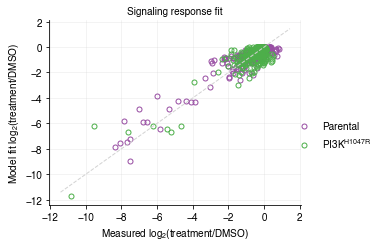

In [16]:
fig, ax = plt.subplots(figsize=cm2inch(14, 9))
lab_dict = {"wt": "Parental", "pi3k": "PI3K$^\mathregular{H1047R}$"}

for cell_line in ["wt", "pi3k"]:
    xvals = sol.rglob[cell_line].values.flatten()
    yvals = sol.rglob_predicted[cell_line].values.flatten()
    plt.plot(xvals, yvals, ".", color = col_dict[cell_line], markersize=10,
             mfc='none', markeredgewidth=1, label=lab_dict[cell_line])

#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
#adds major gridlines
ax.grid(color='lightgrey', linestyle='-', linewidth=0.5, alpha=0.5)

# Adds x=y diagonal
ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", linewidth=1, c="lightgray")
plt.xlabel("Measured log$_\mathregular{2}$(treatment/DMSO)")
plt.ylabel("Model fit log$_\mathregular{2}$(treatment/DMSO)")
plt.title("Signaling response fit")
lgd = ax.legend(frameon=False, loc='upper center', bbox_to_anchor=(1.125,0.5))
plt.tight_layout()

#### Write local response matrices to files

In [17]:
sol.rloc["wt"].to_csv("../results/perturbations/cnr/wt-rloc.csv")
sol.rloc["pi3k"].to_csv("../results/perturbations/cnr/pi3k-rloc.csv")

#### Permutation analysis to assess the significance of model performance

We will asses the statistical significance of the performance of the network model in three ways. 

  1. To assess the overall performance of the network topology we will compare the overall residuals against a model with randomly permute node labels (and permutation annotations, to keep the inhibitor-target node annotation correct.). 
  1. To assess the overall performance of the network topology we will compare the overall residuals against a model with random edges (presence/absence).  
  2. To assess the relevance of the identified differences between WT/mutant, will will compare the residuals to models where random edges are assigned to differ between the cell lines.
 

##### Permuted nodes labels

How many edges do we have in our network model?

In [18]:
n_edges = sol.imap.sum().sum()
all_possible_edges = list(itertools.permutations(NODES, 2))
print(n_edges, len(all_possible_edges))

16 72


In [38]:
%%capture
p = cnr.CnrProblem(panel, eta=0, theta=cplex.infinity, bounds=BOUNDS,
                   prior_network=GIVEN_EDGES+recurrent_additions)

# All perturbation are negative
p.set_pert_sign(
    [(p_name, p_target) for p_name, p_target in PERTS_ANNOT.items() if
     p_name not in DOWNSTREAM_ACTING_INHIBITORS], "neg")

# # Higher concentration have bigger effects
# # RAFi is only measured at a single concentration
add_inhibitor_constraints(p, set(INHIBITORS)-{"RAFi"})

# Get solution without differences between cell lines
p.cpx.solve()
sol_thetaInf = cnr.CnrResult(p)


In [45]:
%%capture
NDRAW = 1000
mssr_shuffled = []
for draw in range(NDRAW):
    # Randomly perturb nodes
    tmp = list(NODES)
    random.shuffle(tmp)
    nodes_shuffled = tuple(tmp)

    wt_shuffled = wt.copy(deep=True)
    wt_shuffled.index = nodes_shuffled

    pi3k_shuffled = pi3k.copy(deep=True)
    pi3k_shuffled.index = nodes_shuffled

    # Keep the inhibitor-node mapping correct
    shuffle_dict = dict(zip(NODES, nodes_shuffled))
    perts_annot_shuffled = {pert: shuffle_dict[node] for pert, node in PERTS_ANNOT.items()}

    panel_shuffled = cnr.PerturbationPanel(
        nodes_shuffled, PERTURBATIONS, perts_annot_shuffled, DOWNSTREAM_ACTING_INHIBITORS,
        rglob={"wt": wt_shuffled, "pi3k": pi3k_shuffled}
    )

    p_shuffled = cnr.CnrProblem(panel_shuffled, eta=0, theta=cplex.infinity, bounds=BOUNDS,
                       prior_network=GIVEN_EDGES+recurrent_additions)

    # All perturbation are negative
    p_shuffled.set_pert_sign(
        [(p_name, p_target) for p_name, p_target in perts_annot_shuffled.items() if
         p_name not in DOWNSTREAM_ACTING_INHIBITORS], "neg")

    # Higher concentration have bigger effects
    # RAFi is only measured at a single concentration
    add_inhibitor_constraints(p_shuffled, set(INHIBITORS)-{"RAFi"})

    # Get solution without differences between cell lines
    p_shuffled.cpx.solve()

    # Get the error of the solution
    mssr = cnr.CnrResult(p_shuffled).mssr
    mssr_shuffled.append(mssr)
    with open("../results/perturbations/cnr/rms-permuted-nodelabels.txt", "w") as f:
        for item in mssr_shuffled:
            f.write("%s\n" % item)

with open("../results/perturbations/cnr/rms-permuted-nodelabels.txt", "r") as f:
    mssr_shuffled = [float(mssr) for mssr in f.read().splitlines()]


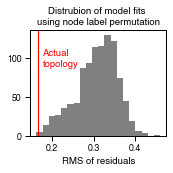

In [56]:
sns.set_context('paper')
plt.figure(figsize=(2.5, 2.5))
plt.hist(mssr_shuffled, bins=20, color="gray");
plt.axvline(sol_thetaInf.mssr, color='red');
plt.xlabel("RMS of residuals");
plt.title("Distrubion of model fits \nusing node label permutation");
plt.text(sol_thetaInf.mssr + 0.01, 90, "Actual\ntopology", color='red')
plt.tight_layout()
plt.savefig("../figures/cnr/rms-permuted-nodelabels.pdf")

In [58]:
pval = np.sum(mssr_shuffled < sol_thetaInf.mssr)/len(mssr_shuffled)
pval

0.001

##### Random edges

In [20]:
%%capture
p = cnr.CnrProblem(panel, eta=0, theta=cplex.infinity, bounds=BOUNDS,
                   prior_network=GIVEN_EDGES+recurrent_additions)

# All perturbation are negative
p.set_pert_sign(
    [(p_name, p_target) for p_name, p_target in PERTS_ANNOT.items() if
     p_name not in DOWNSTREAM_ACTING_INHIBITORS], "neg")

# Higher concentration have bigger effects
# RAFi is only measured at a single concentration
add_inhibitor_constraints(p, set(INHIBITORS)-{"RAFi"})

# Get solution without differences between cell lines
p.cpx.solve()
sol_thetaInf = cnr.CnrResult(p)

# NDRAW = 1000
# mssr_random = []
# for draw in range(NDRAW):
#     p = cnr.CnrProblem(panel, eta=0, theta=cplex.infinity, bounds=BOUNDS,
#                        prior_network=random.sample(all_possible_edges, n_edges))

#     # All perturbation are negative
#     p.set_pert_sign(
#         [(p_name, p_target) for p_name, p_target in PERTS_ANNOT.items() if
#          p_name not in DOWNSTREAM_ACTING_INHIBITORS], "neg")

#     # Higher concentration have bigger effects
#     # RAFi is only measured at a single concentration
#     add_inhibitor_constraints(p, set(INHIBITORS)-{"RAFi"})

#     p.cpx.solve()
#     mssr = cnr.CnrResult(p).mssr
#     mssr_random.append(mssr)
# with open("../results/perturbations/cnr/rms-random-edges.txt", "w") as f:
#     for item in mssr_random:
#         f.write("%s\n" % item)

with open("../results/perturbations/cnr/rms-random-edges.txt", "r") as f:
    mssr_random = [float(mssr) for mssr in f.read().splitlines()]


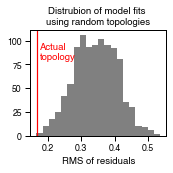

In [21]:
sns.set_context('paper')
plt.figure(figsize=(2.5, 2.5))
plt.hist(mssr_random, bins=20, color="gray");
plt.axvline(sol_thetaInf.mssr, color='red');
plt.xlabel("RMS of residuals");
plt.title("Distrubion of model fits \nusing random topologies");
plt.text(sol_thetaInf.mssr + 0.01, 80, "Actual\ntopology", color='red')
plt.tight_layout()
plt.savefig("../figures/cnr/rms-random-edges.pdf")

##### Random differences

How many differences are identified by CNR?

In [25]:
total_deviations = int(sum(
    [status for indicator, status in sol.vardict.items() if
     indicator.startswith(('IDev', 'Imerged'))]))
total_deviations

13

In [28]:
all_dev_indicators = [indicator for indicator in sol.vardict.keys() if indicator.startswith(('IDev', 'Imerged'))]
len(all_dev_indicators)


28

In [118]:
%%capture

mssr_random_dev = []
for draw in range(1000):
    p = cnr.CnrProblem(panel, eta=0, theta=0, bounds=BOUNDS,
                       prior_network=GIVEN_EDGES+recurrent_additions)

    # All perturbation are negative
    p.set_pert_sign(
        [(p_name, p_target) for p_name, p_target in PERTS_ANNOT.items() if
         p_name not in DOWNSTREAM_ACTING_INHIBITORS], "neg")

    # Higher concentration have bigger effects
    # RAFi is only measured at a single concentration
    add_inhibitor_constraints(p, set(INHIBITORS)-{"RAFi"})


    # Merge the indicators corresponding to the same inihibitor
    for inhib, target in INHIB_TARGET_PAIRS_2:
        indicators_to_merge = select_indicators_to_merge(
            inhib, target, p.cpx.variables.get_names()
        )
        merged_indicator_name = "_".join(
            ["Imerged".split("_")[0], inhib, target])
        p.merge_indicators(indicators_to_merge, merged_indicator_name)


    # Get all Dev indicators
    all_dev_indicators = [indicator for indicator in sol.vardict.keys() if 
                          indicator.startswith(('IDev', 'Imerged'))]

    # Set random selection of Dev indicators to active
    set_active = random.sample(all_dev_indicators, total_deviations)
    for indicator in all_dev_indicators:
        if indicator in set_active:
            cnr.cplexutils.set_indicator_status(p.cpx, indicator, 1)
        else:
            cnr.cplexutils.set_indicator_status(p.cpx, indicator, 0)


    # for indicator, status in sol.vardict.items():
    #     if indicator.startswith(('IDev', 'Imerged')):
    #         cnr.cplexutils.set_indicator_status(p.cpx, indicator, status)

    p.cpx.solve()
    tmp = cnr.CnrResult(p)
    mssr_random_dev.append(tmp.mssr)


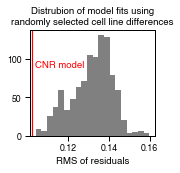

In [134]:
sns.set_context('paper')
plt.figure(figsize=(2.5, 2.5))
plt.hist(mssr_random_dev, bins=20, color="gray");
plt.axvline(sol.mssr, color='red');
plt.xlabel("RMS of residuals");
plt.title("Distrubion of model fits using\nrandomly selected cell line differences");
plt.text(sol.mssr+0.0015, 90, "CNR model", color='red')
plt.tight_layout()
plt.savefig("../figures/cnr/rms-random-diffrences.pdf")

### Parametrize the relation between drug-concentration and target-inhibition

In the CNR reconstruction, we obtain estimates for direct target inhibition effect for each inhibitor for two concentrations, the IC50 and the IC90.
We can use these estimates to parametrize a relation between drug concentration and target inhibition, which will allow us to "simulate" the effect of an arbitrary drug concentration.

For each inhibitor-target pair, we fit a curve of the form:

$$s_{ij} = I_{max}\frac{[I]}{K_I + [I]}$$

where $s_{ij}$ is the strength of target inhibition, $[I]$ the inhibitor concentration, $I_{max}$ the asymptote of $s_{ij}$ for $[I] \rightarrow \infty$ and $K_I$ the inhibitor concentration for which the half-maximal $s_{ij}$ is attained.

For convenience, all inhibitor concentrations are relative to the IC90 (i.e. highest one measured)

In [59]:
# First extract the information about inhibitor-target pairs from the solution
df_inhib = []    
for var, val in sol.vardict.items():
    if var.split("_")[0] in ["rp", "rpDS"] :
        cl, pert_name, pert_target = var.split("_")[1:]
        concentration = re.split(r"(\d+uM)", pert_name)[1].replace("uM", "")
        inhibitor = re.split(r"(\d+uM)", pert_name)[0]
        if concentration[0] == "0":
            concentration = "."+concentration[1:]
        concentration = float(concentration)
        df_inhib.append((var, cl, pert_name, pert_target, 
                         inhibitor, concentration, val))
df_inhib = pd.DataFrame(df_inhib,
                        columns=["var", "cl", "pert_name", 
                                "target", "inhibitor", "concentration", "value"])
df_inhib = df_inhib.sort_values(by = ["inhibitor", "target", "cl", "concentration"])
df_ic90 = df_inhib[["inhibitor", 'concentration']].groupby("inhibitor").max().reset_index()
df_ic90.columns = ['inhibitor', 'IC90']
df_inhib = df_inhib.merge(df_ic90, how = 'inner', on = ['inhibitor'])
df_inhib['normalized_concentration'] = df_inhib.concentration/df_inhib.IC90
df_inhib.head()

,var,cl,pert_name,target,inhibitor,concentration,value,IC90,normalized_concentration
0,rp_pi3k_AKTi1uM_BioAkt,pi3k,AKTi1uM,BioAkt,AKTi,1.0,-4.135642,5.0,0.2
1,rp_pi3k_AKTi5uM_BioAkt,pi3k,AKTi5uM,BioAkt,AKTi,5.0,-7.858624,5.0,1.0
2,rp_wt_AKTi1uM_BioAkt,wt,AKTi1uM,BioAkt,AKTi,1.0,-5.065007,5.0,0.2
3,rp_wt_AKTi5uM_BioAkt,wt,AKTi5uM,BioAkt,AKTi,5.0,-6.627811,5.0,1.0
4,rp_pi3k_EGFRi03uM_EGFR,pi3k,EGFRi03uM,EGFR,EGFRi,0.3,-0.358692,1.0,0.3


In [60]:
def inhib_curve(x, imax, ki):
    return imax*x / (ki + x)

df_param = []
lst_param = []
for i, t in INHIB_TARGET_PAIRS_2:
    for cell_line in ["wt", "pi3k"]:
        df_it = df_inhib[(df_inhib.inhibitor == i) & 
                       (df_inhib.target == t) & 
                       (df_inhib.cl == cell_line)]
        yvals = [0] + list(df_it.value)
        xvals = [0] + list(df_it.normalized_concentration)
        
        if max(map(abs, yvals)) > 1e-6:
            imax, ki = scipy.optimize.curve_fit(
                inhib_curve, xvals, yvals, 
                bounds = ([-100, 0], [0, 100]))[0]
        else: 
            imax, ki = 0, np.Infinity
        df_param.append((i, t, cell_line, imax, ki))
        
df_param = pd.DataFrame(df_param, 
                        columns=["inhibitor", "target", "cl", "imax", "ki"])                
df_param = df_param.sort_values(by = ["inhibitor", "target"])
df_merged = df_inhib.merge(df_param, how = 'inner', on = ['target', 'inhibitor', "cl"])

df_param.head()

/Users/evertbosdriesz/opt/miniconda3/envs/mcf10a-pi3k/lib/python3.6/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


,inhibitor,target,cl,imax,ki
14,AKTi,BioAkt,wt,-7.181796,0.083585
15,AKTi,BioAkt,pi3k,-10.140875,0.290414
4,EGFRi,EGFR,wt,-0.453925,0.079651
5,EGFRi,EGFR,pi3k,-0.453925,0.079651
18,ERKi,ERK1,wt,-2.004277,0.033407


In [61]:

def plot_curve(df, i, t, deviating=set()):
    
    # Set up the figure
    fig, ax = plt.subplots(figsize=cm2inch(12/1.2,9/1.2))
    
    # Add the plot data
    for cell_line in ["wt", "pi3k"]:
        df_itc = df[(df.inhibitor == i) & (df.target == t) & (df.cl == cell_line)]
        
        imax = float(df_itc.imax.unique())
        ki   = float(df_itc.ki.unique())

        yvals = [0] + list(df_itc.value)
        xvals = [0] + list(df_itc.normalized_concentration)

        xfitvals = np.arange(0, max(xvals), max(xvals)/100)
        yfitvals = [inhib_curve(x, imax, ki) for x in xfitvals]
        yfitvals = [float(y) for y in yfitvals]
        
        if (i, t) in deviating:
            plt.plot(xvals, yvals, "o", color = col_dict[cell_line], markersize=4)
            plt.plot(xfitvals, yfitvals, "--", color = col_dict[cell_line])
        else:
            plt.plot(xvals, yvals, "o", color = 'gray', markersize=4)
            plt.plot(xfitvals, yfitvals, "--", color = 'gray')
        
    #removing top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #adds major gridlines
    ax.grid(color='lightgrey', linestyle='-', linewidth=0.25)
    
    # Axis labels and title
    if t == "BioAkt": t = "AKT1" # Don't use BioAkt to refer to AKT in plot labels
    plt.xlabel("["+i+"] (relative to IC90)")
    plt.ylabel("Perturbation effect")
    plt.title(" ".join(["Direct effect of",i,"on",t]))
    plt.tight_layout()

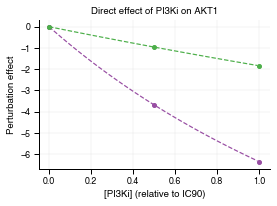

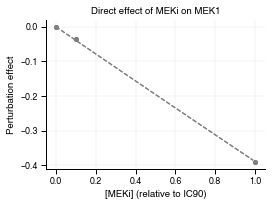

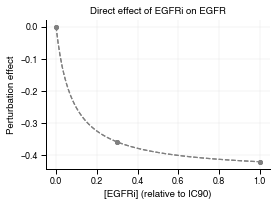

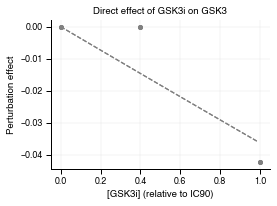

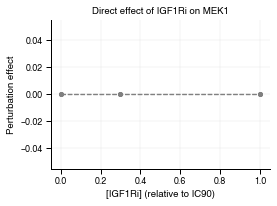

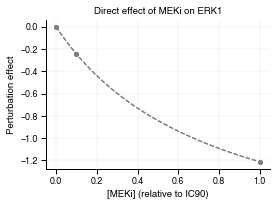

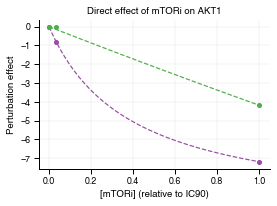

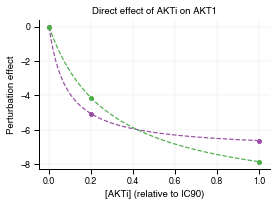

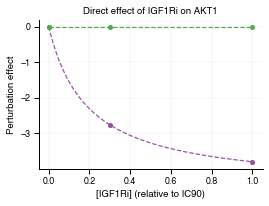

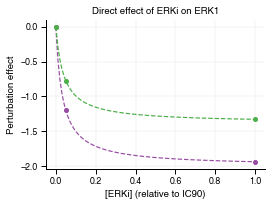

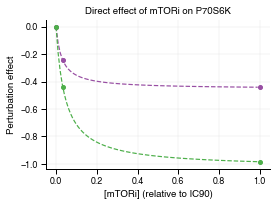

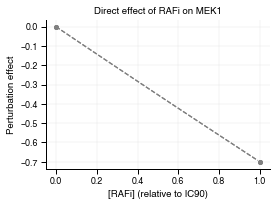

In [62]:
deviating_inhibib_target_pairs = set()
for var in list(sol.deviations_overview().index):
    if var.split("_")[0] in ["rp", "rpDS"]:
        i, t = var.split("_")[1], var.split("_")[2]
        i = i.split('i')[0]+"i"
        deviating_inhibib_target_pairs.add((i, t))


for i, t, in INHIB_TARGET_PAIRS_2:
    plot_curve(df_merged, i, t, deviating = deviating_inhibib_target_pairs)
    fname = str(i)+"-"+str(t)+".pdf"
    # plt.savefig("../figures/cnr/inhibitor-targetinhibition-curves/"+fname)
    plt.show()
    plt.close()

#### Write the parameters and drug concentrations to files

In [63]:
# Write the applied inhibitor concentrations to file
tmp = df_inhib[["inhibitor", "concentration", "IC90", "normalized_concentration"]]
tmp = tmp[tmp.concentration != tmp.IC90].drop_duplicates()
tmp.columns = ['Inhibitor', "IC50", "IC90", "NormalizedIC50"]
tmp.to_csv("../results/perturbations/drug-concentrations.tsv", sep = "\t", index = False)

In [64]:
df_merged.to_csv("../results/perturbations/cnr/target-inhibition-parametrization.csv")

### Mapping inhibitor concentrations to signaling response 

In order to simulate/predict the direct target-inhibition effects of arbitrary drug combinations (i.e. elements of $s_{ij}$) we need to parametrize a mapping from inhibitor-concentration to target-inhibition.
Here, we prepare and export this vector for use in Mathematica, which we will use to perform the drug-combination-optimizations.

In [65]:
# Generate matrices of NODESxINHIBITORS with the KIs and IMAX values, to use as
# input over vectorized inhib_curve_vec function
# WT
mat_imax_wt = df_param[df_param.cl == "wt"][["inhibitor", "target", "imax"]]
mat_imax_wt = mat_imax_wt.pivot("target","inhibitor", "imax")
mat_imax_wt = np.nan_to_num(mat_imax_wt.reindex(index = NODES, columns=INHIBITORS))
mat_ki_wt = df_param[df_param.cl == "wt"][["inhibitor", "target", "ki"]]
mat_ki_wt = mat_ki_wt.pivot("target","inhibitor", "ki")
mat_ki_wt = np.nan_to_num(mat_ki_wt.reindex(index = NODES, columns=INHIBITORS))
# # PI3K
mat_imax_pi3k = df_param[df_param.cl == "pi3k"][["inhibitor", "target", "imax"]]
mat_imax_pi3k = mat_imax_pi3k.pivot("target","inhibitor", "imax")
mat_imax_pi3k = np.nan_to_num(mat_imax_pi3k.reindex(index = NODES, columns=INHIBITORS))
mat_ki_pi3k = df_param[df_param.cl == "pi3k"][["inhibitor", "target", "ki"]]
mat_ki_pi3k = mat_ki_pi3k.pivot("target","inhibitor", "ki")
mat_ki_pi3k = np.nan_to_num(mat_ki_pi3k.reindex(index = NODES, columns=INHIBITORS))

# Matrix indicating which nodes are affected by each inhibitor.
inhib_map = np.zeros(shape = np.shape(mat_imax_wt))
for inhib, target in INHIB_TARGET_PAIRS_2:
    inhib_map[NODES.index(target), INHIBITORS.index(inhib)] = 1

# Nonzero elements to use in vectorized curve fit
idx_to_use = np.nonzero(inhib_map)

def inhib_curve_symbol(inhib_symbol, imax, ki):
    return imax*inhib_symbol / (ki + inhib_symbol)

# Generate vector that gives target-inhibition of each node as function of 
# inhibitor concentration

# WT
# Generate NODESxINHIBITOR matrix where each non-zero element quantifies the 
# target-inhibition effect of INHIBITOR on NODE
rp_wt = np.zeros(np.shape(inhib_map), dtype=sympy.Symbol)
rp_wt[idx_to_use] = np.vectorize(inhib_curve_symbol)(
    np.dot(inhib_map, np.identity(len(INHIBITORS))*[sympy.Symbol(i) for i in INHIBITORS])[idx_to_use],
    mat_imax_wt[idx_to_use], mat_ki_wt[idx_to_use]
)
# Sum over all inhibitors 
rp_wt = pd.Series(rp_wt.sum(axis=1), index = NODES)

# PI3K 
rp_pi3k = np.zeros(np.shape(inhib_map), dtype=sympy.Symbol)
rp_pi3k[idx_to_use] = np.vectorize(inhib_curve_symbol)(
    np.dot(inhib_map, np.identity(len(INHIBITORS))*[sympy.Symbol(i) for i in INHIBITORS])[idx_to_use],
    mat_imax_pi3k[idx_to_use], mat_ki_pi3k[idx_to_use]
)
rp_pi3k = pd.Series(rp_pi3k.sum(axis=1), index = NODES)

Let's perform some sanity check on the exported perturbation-vectors.

In [66]:
print(rp_wt.EGFR)
print(rp_pi3k.EGFR)
df_param[df_param.target == "EGFR"]

-0.453925468968977*EGFRi/(1.0*EGFRi + 0.0796509922253572)
-0.453925468968977*EGFRi/(1.0*EGFRi + 0.0796509922253572)


,inhibitor,target,cl,imax,ki
4,EGFRi,EGFR,wt,-0.453925,0.079651
5,EGFRi,EGFR,pi3k,-0.453925,0.079651


In [67]:
print("WT:   ", rp_wt.BioAkt)
print("PI3K: ", rp_pi3k.BioAkt)
df_param[df_param.target == "BioAkt"]

WT:    -7.18179597911812*AKTi/(1.0*AKTi + 0.0835848407483674) - 4.54040595058919*IGF1Ri/(1.0*IGF1Ri + 0.192867265168982) - 23.2292474286028*PI3Ki/(1.0*PI3Ki + 2.64992800836348) - 9.98518677489375*mTORi/(1.0*mTORi + 0.388827878687453)
PI3K:  -10.1408747327125*AKTi/(1.0*AKTi + 0.290413572868903) - 22.5725911008527*PI3Ki/(1.0*PI3Ki + 11.2417391675109) - 99.9999999994269*mTORi/(1.0*mTORi + 22.8910211262826)


,inhibitor,target,cl,imax,ki
14,AKTi,BioAkt,wt,-7.181796,0.083585
15,AKTi,BioAkt,pi3k,-10.140875,0.290414
16,IGF1Ri,BioAkt,wt,-4.540406,0.192867
17,IGF1Ri,BioAkt,pi3k,0.000000,inf
0,PI3Ki,BioAkt,wt,-23.229247,2.649928
1,PI3Ki,BioAkt,pi3k,-22.572591,11.241739
12,mTORi,BioAkt,wt,-9.985187,0.388828
13,mTORi,BioAkt,pi3k,-100.000000,22.891021


#### Write the responses to file

In [68]:
rp_wt.to_csv('../results/perturbations/cnr/wt-inhibitor-response.csv', header=False)
rp_pi3k.to_csv('../results/perturbations/cnr/pi3k-inhibitor-response.csv', header=False)

We can also generate the expression that simulates the overall network response $\mathbf{R}$ by simply calculating 
$$\mathbf{R} = -\mathbf{r}^{-1}\mathbf{s}$$
(where s is the vector calculated above).
We also export this for convenience.

In [69]:
response_wt = -1*np.dot(np.linalg.inv(sol.rloc['wt']), rp_wt)
with open('../results/perturbations/cnr/wt_network-response.csv', 'w') as the_file:
    the_file.write(",".join([sympy.printing.mathematica_code(i) for i in list(response_wt)]))
    
response_pi3k = -1*np.dot(np.linalg.inv(sol.rloc['pi3k']), rp_pi3k)
with open('../results/perturbations/cnr/pi3k_network-response.csv', 'w') as the_file:
    the_file.write(",".join([sympy.printing.mathematica_code(i) for i in list(response_pi3k)]))
    
response_symbolic = {"wt": response_wt, "pi3k":response_pi3k}

### Visualize the network

We write the network reconstruction to a `.gml` file for visualization in cytoscape.

In [73]:
 rename_dict = {
        'AKTi1uM': "AKTi",'AKTi5uM': "AKTi",
        'EGFRi03uM': "EGFRi", 'EGFRi1uM': "EGFRi",
        'ERKi002uM': 'ERKi', 'ERKi04uM': "ERKi",
        'IGF1Ri10uMakt': "IGF1Ri", 'IGF1Ri10uMmek': "IGF1Ri",
        'IGF1Ri3uMakt': "IGF1Ri", 'IGF1Ri3uMmek': "IGF1Ri",
        'MEKi0002uM': "MEKi", 'MEKi002uM': "MEKi", 
        'PI3Ki1uM': "PI3Ki", 'PI3Ki2uM': "PI3Ki",
        'RAFi1uM': "RAFi", 
        'mTORi001uMmtorc1': "mTORi", 'mTORi03uMmtorc1': "mTORi",
        'mTORi001uMmtorc2': "mTORi", 'mTORi03uMmtorc2': "mTORi"
    }
    
INHIBITORS

['AKTi', 'EGFRi', 'ERKi', 'GSK3i', 'IGF1Ri', 'MEKi', 'PI3Ki', 'RAFi', 'mTORi']

In [90]:
PERTURBATIONS

[['IGF1Ri3uMmek', 'IGF1Ri3uMakt'],
 ['IGF1Ri10uMmek', 'IGF1Ri10uMakt'],
 ['EGFRi03uM'],
 ['EGFRi1uM'],
 ['RAFi1uM'],
 ['MEKi0002uM', 'MEKi0002uMds'],
 ['MEKi002uM', 'MEKi002uMds'],
 ['ERKi002uM'],
 ['ERKi04uM'],
 ['GSK3i2uM'],
 ['GSK3i5uM'],
 ['PI3Ki1uM'],
 ['PI3Ki2uM'],
 ['AKTi1uM'],
 ['AKTi5uM'],
 ['mTORi001uMmtorc1', 'mTORi001uMmtorc2'],
 ['mTORi03uMmtorc1', 'mTORi03uMmtorc2'],
 ['EGFRi03uM', 'IGF1Ri3uMmek', 'IGF1Ri3uMakt'],
 ['EGFRi03uM', 'MEKi0002uM', 'MEKi0002uMds'],
 ['EGFRi03uM', 'ERKi002uM'],
 ['MEKi0002uM', 'MEKi0002uMds', 'ERKi002uM'],
 ['IGF1Ri3uMmek', 'IGF1Ri3uMakt', 'AKTi1uM'],
 ['IGF1Ri3uMmek', 'IGF1Ri3uMakt', 'mTORi001uMmtorc1', 'mTORi001uMmtorc2'],
 ['PI3Ki1uM', 'mTORi001uMmtorc1', 'mTORi001uMmtorc2'],
 ['AKTi1uM', 'mTORi001uMmtorc1', 'mTORi001uMmtorc2'],
 ['EGFRi03uM', 'PI3Ki1uM'],
 ['EGFRi03uM', 'AKTi1uM'],
 ['EGFRi03uM', 'mTORi001uMmtorc1', 'mTORi001uMmtorc2'],
 ['MEKi0002uM', 'MEKi0002uMds', 'PI3Ki1uM'],
 ['ERKi002uM', 'PI3Ki1uM'],
 ['ERKi002uM', 'AKTi1uM']]

In [91]:
# Use this to merge the 'inhibitor-nodes' corresponding to the same 
# inhibitor-target pair
def merge_nodes(G, nodes, new_node):
    """
    Merges the selected `nodes` of the graph G into one `new_node`,
    meaning that all the edges that pointed to or from one of these
    `nodes` will point to or from the `new_node`.
    attr_dict and **attr are defined as in `G.add_node`.
    """
    G.add_node(new_node, type= "perturbation") # Add the 'merged' node  
    new_edges = []
    for n1, n2, data in G.edges(data=True):
        # For all edges related to one of the nodes to merge,
        # make an edge going to or coming from the `new gene`.
        if n1 in nodes:
            new_edges.append((new_node, n2, data))
        elif n2 in nodes:
            new_edges.append((n1, new_node,data))
    G.add_edges_from(new_edges)
    
    for n in nodes: # remove the merged nodes
        G.remove_node(n)
        
def remove_edges(G, weigth_cutoff = 0.0):
    "Remove edges from graph G is the weigth < weight_cutoff (default =0)"
    edges_to_remove = []
    for i, j, weight in G.edges(data="weight"):
        if abs(weight) < weigth_cutoff:
            edges_to_remove.append((i, j))
    G.remove_edges_from(edges_to_remove)

# The main writing functions
def write_perturbation_gml(G_original, fname, 
                           pertlabels,
                           maxwidth=10., weigth_cutoff = 0.0,
                           nodes_drop=None, highlight_diff = True,
                           given_edges = GIVEN_EDGES):
    "Write the reconstructed network to a gml file"

    G = G_original.copy()
    # Remove selected nodes and edges
    if nodes_drop:
        G.remove_nodes_from(nodes_drop)
    remove_edges(G, weigth_cutoff)      
   
    # Make inhibitor-node names more concice (and matching graph_pos)
    rename_dict = {
        'AKTi1uM': "AKTi",'AKTi5uM': "AKTi",
        'EGFRi03uM': "EGFRi", 'EGFRi1uM': "EGFRi",
        'ERKi002uM': 'ERKi', 'ERKi04uM': "ERKi",
        'IGF1Ri10uMakt': "IGF1Ri", 'IGF1Ri10uMmek': "IGF1Ri",
        'IGF1Ri3uMakt': "IGF1Ri", 'IGF1Ri3uMmek': "IGF1Ri",
        'MEKi0002uM': "MEKi", 'MEKi002uM': "MEKi", 'MEKi002uMds': "MEKi", 'MEKi0002uMds': "MEKi",
        'PI3Ki1uM': "PI3Ki", 'PI3Ki2uM': "PI3Ki",
        'RAFi1uM': "RAFi", 
        'mTORi001uMmtorc1': "mTORi", 'mTORi03uMmtorc1': "mTORi",
        'mTORi001uMmtorc2': "mTORi", 'mTORi03uMmtorc2': "mTORi",
        'GSK3i2uM': 'GSK3i', "GSK3i5uM": "GSK3i"
    }
    G = nx.relabel_nodes(G, rename_dict)      
    G = nx.relabel_nodes(G, {'BioAkt': 'AKT1'})
    
    # Add the node-positioning information.
    graph_pos = {
        # Nodes
        'EGFR': (0, 0), 
        'MEK1': (.75, -1), 
        'ERK1': (.75, -2), 
        'CREB1': (1.25, -3),
        'AKT1': (-.75, -1), 
        'PRAS40': (-.75, -2), 
        'P70S6K': (0, -3), 
        'GSK3': (.75, -3.5),
        'RS6': (-.75, -3.5),

        # Inhibitors
        "IGF1Ri": (-.75, 0.),
        "EGFRi": (0., 1), 
        "RAFi": (2, -0.5), 
        "MEKi": (2, -1), 
        "ERKi": (2, -2), 
        "GSK3i": (2, -2.5),
        "PI3Ki": (-2, -0.5),
        "AKTi": (-2, -1), 
        "mTORi": (-2, -2)
    }
    pos_x = dict()
    pos_y = dict()
    for key, val in graph_pos.items():
        pos_x[key] = int(35*val[0])
        pos_y[key] = int(-35*val[1])
    nx.set_node_attributes(G, pos_x, name='x')
    nx.set_node_attributes(G, pos_y, name='y')

    # Make feedback edge curved
    d = {key: 0 for key in G.edges()}
    d[("P70S6K", "AKT1")] = 1
    d[("PRAS40", "AKT1")] = 1
    d[("RS6", "AKT1")] = 1
    d[("GSK3", "AKT1")] = 1
    d[("ERK1", "MEK1")] = 1
    d[("ERK1", "EGFR")] = 1
    
    #d[("RS6", "PRAS40")] = 1
    
    nx.set_edge_attributes(G, d, name = "curved")
        
    if highlight_diff:
        for parent, child in G.edges():
            # if G[parent][child]['deviation'] == 0.:
            G[parent][child]['color'] = 'gray'
    
    # Set maximum width on edges
    for i, j, pw in G.edges(data="penwidth"):
        if pw > maxwidth:
            G[i][j]['penwidth'] = maxwidth
    
    # Set edge labels
    for parent, child, w in G.edges(data="weight"):
        #if G[parent][child]['deviation'] == 1:
            # Don't show labels of perturbations
        if G[parent][child]["edgetype"] != 'perturbation':
            G[parent][child]['edgelabel'] = str(np.round(w, 2))
            # else:
            #   G[parent][child]['edgelabel'] = pertlabels[(parent, child)]

    
    # Annotate if the edge was added to the network or was in the supplied 
    # starting network
    for parent, child in G.edges():
        if (child.replace("AKT1", "BioAkt").strip(),
            parent.replace("AKT1", "BioAkt").strip()) in given_edges:
            G[parent][child]["added"] = True
        else:
            G[parent][child]["added"] = False
    
    nx.write_gml(G, fname)
    return G

# The main writing functions
def write_perturbation_combined_gml(
    sol, fname, pertlabels, maxwidth=10., weigth_cutoff = 0.0,
    nodes_drop=None, highlight_diff = True, given_edges = GIVEN_EDGES):
    "Write the reconstructed network to a gml file"

    G   = cnr.cnrplot.graph_from_sol(sol, "wt")
    G_pi3k = cnr.cnrplot.graph_from_sol(sol, "pi3k")
    # Remove selected nodes and edges
    if nodes_drop:
        G.remove_nodes_from(nodes_drop)
    remove_edges(G, weigth_cutoff)      
   
    # Make inhibitor-node names more concice (and matching graph_pos)
    rename_dict = {
        'AKTi1uM': "AKTi",'AKTi5uM': "AKTi",
        'EGFRi03uM': "EGFRi", 'EGFRi1uM': "EGFRi",
        'ERKi002uM': 'ERKi', 'ERKi04uM': "ERKi",
        'IGF1Ri10uMakt': "IGF1Ri", 'IGF1Ri10uMmek': "IGF1Ri",
        'IGF1Ri3uMakt': "IGF1Ri", 'IGF1Ri3uMmek': "IGF1Ri",
        'MEKi0002uM': "MEKi", 'MEKi002uM': "MEKi",  'MEKi002uMds': "MEKi", 'MEKi0002uMds': "MEKi",
        'PI3Ki1uM': "PI3Ki", 'PI3Ki2uM': "PI3Ki",
        'RAFi1uM': "RAFi", 
        'mTORi001uMmtorc1': "mTORi", 'mTORi03uMmtorc1': "mTORi",
        'mTORi001uMmtorc2': "mTORi", 'mTORi03uMmtorc2': "mTORi",
        'GSK3i2uM': 'GSK3i', "GSK3i5uM": "GSK3i"
    }
    G = nx.relabel_nodes(G, rename_dict)      
    G = nx.relabel_nodes(G, {'BioAkt': 'AKT1'})
    
    G_pi3k = nx.relabel_nodes(G_pi3k, rename_dict)      
    G_pi3k = nx.relabel_nodes(G_pi3k, {'BioAkt': 'AKT1'})
    
    # Add the node-positioning information.
    graph_pos = {
        # Nodes
        'EGFR': (0, 0), 
        'MEK1': (.75, -1), 
        'ERK1': (.75, -2), 
        'CREB1': (1.25, -3),
        'AKT1': (-.75, -1), 
        'PRAS40': (-.75, -2), 
        'P70S6K': (0, -3), 
        'GSK3': (.75, -3.5),
        'RS6': (-.75, -3.5),

        # Inhibitors
        "IGF1Ri": (-.75, 0.),
        "EGFRi": (0., 1), 
        "RAFi": (2, -0.5), 
        "MEKi": (2, -1), 
        "ERKi": (2, -2), 
        "GSK3i": (2, -2.5),
        "PI3Ki": (-2, -0.5),
        "AKTi": (-2, -1), 
        "mTORi": (-2, -2)
    }
    pos_x = dict()
    pos_y = dict()
    for key, val in graph_pos.items():
        pos_x[key] = int(35*val[0])
        pos_y[key] = int(-35*val[1])
    nx.set_node_attributes(G, pos_x, name='x')
    nx.set_node_attributes(G, pos_y, name='y')

    # Make feedback edge curved
    d = {key: False for key in G.edges()}
    d[("PRAS40", "AKT1")] = True
    d[("RS6", "AKT1")] = True
    d[("GSK3", "AKT1")] = True
    d[("GSK3", "EGFR")] = True
#     d[("ERK1", "EGFR")] = True
    
#     d[("RS6", "PRAS40")] = True
    
    nx.set_edge_attributes(G, d, name = "curved")
        
    if highlight_diff:
        for parent, child in G.edges():
            if G[parent][child]['deviation'] == 0.:
                G[parent][child]['color'] = 'gray'
            else:
                G[parent][child]['color'] = '#1c86ee'
    
    # Set maximum width on edges
    for i, j, pw in G.edges(data="penwidth"):
        if pw > maxwidth:
            G[i][j]['penwidth'] = maxwidth
    
    # Set edge labels
    for parent, child, w in G.edges(data="weight"):
        # Don't show labels of perturbations
        if G[parent][child]["edgetype"] != 'perturbation':
            if G[parent][child]['deviation'] == 1:
                label_wt = str(np.round(w, 2))
                label_pi3k = str(np.round(G_pi3k[parent][child]['weight'], 2))
                label = label_wt + "/" + label_pi3k
                G[parent][child]['edgelabel'] = label
            # else:
            #   G[parent][child]['edgelabel'] = pertlabels[(parent, child)]

    
    # Annotate if the edge was added to the network or was in the supplied 
    # starting network
    for parent, child in G.edges():
        if (child.replace("AKT1", "BioAkt").strip(),
            parent.replace("AKT1", "BioAkt").strip()) in given_edges:
            G[parent][child]["added"] = True
        else:
            G[parent][child]["added"] = False
    
    nx.write_gml(G, fname)
    return G

In [92]:
pertlabels = dict()
for cl in ['wt', 'pi3k']:
    pertlabels[cl] = dict()
    for i, t in INHIB_TARGET_PAIRS_2:
        sel = (df_inhib.cl == cl) & (df_inhib.inhibitor == i) & \
              (df_inhib.target == t)
        lab = ','.join([str(x) for x in np.round(df_inhib[sel].value, 2)])
        pertlabels[cl][(i.replace('BioAkt', "AKT1"), 
                        t.replace('BioAkt', "AKT1").strip())] = lab


In [93]:
g_wt   = cnr.cnrplot.graph_from_sol(sol, "wt", 1.5)
g_pi3k = cnr.cnrplot.graph_from_sol(sol, "pi3k", 1.5)


def flatten_list(lst):
    """Flatten list of lists."""
    return [item for sublist in lst for item in sublist]


perturbation_nodes = set(flatten_list(sol.perts))
deviations = [i.split("_")[1] for i in sol.deviations_overview().index]
nodes_drop = None#(perturbation_nodes - set(deviations))

g = write_perturbation_gml(
    g_wt,
    "../results/perturbations/cnr/wt-network.gml",
    pertlabels['wt'],
    maxwidth=10.,
    weigth_cutoff = 0.,
    nodes_drop = nodes_drop,
    given_edges = GIVEN_EDGES
)

write_perturbation_gml(
    g_pi3k,
    "../results/perturbations/cnr/pi3k-network.gml",
    pertlabels['pi3k'],
    maxwidth=10.,
    weigth_cutoff = 0.,
    nodes_drop = nodes_drop,
    given_edges = GIVEN_EDGES
)


g = write_perturbation_combined_gml(
    sol,
    "../results/perturbations/cnr/combined-network.gml",
    pertlabels['wt'],
    maxwidth=10.,
    weigth_cutoff = 0.,
    nodes_drop = nodes_drop,
    given_edges = GIVEN_EDGES
)


# Evaluate full model fit

In another notebook we parametrized a model relating AKT and ERK response to viability of the following form:

$$\mathrm{viability} \sim \frac{1}{1-\Delta ERK1/KM_{ERK1}-{\Delta AKT/KM_{AKT}}}$$

and fitted the parameters $KM_{ERK}$ and $KM_{AKT}$.


Finally, we combine the signaling network and viability model to see how well the complete model fits the perturbation data.

First, we need to import the viability data and the obtained parameters.


In [30]:
mapping_combined = {
    'wt':{'KM_ERK': KM_ERK_WT, 'KM_AKT': KM_AKT_WT},
    'pi3k':{'KM_ERK': KM_ERK_PI3K, 'KM_AKT': KM_AKT_PI3K}
}

wt_viability = pd.read_csv("../results/perturbations/wt-envision.tsv", 
                           sep="\t", index_col=0)
pi3k_viability = pd.read_csv("../results/perturbations/pi3k-envision.tsv", 
                             sep="\t", index_col=0)

responses = df_fit.pivot_table(
    index=['cell_line','inhibitor'], columns='node', values='fitted'
)[['BioAkt', 'ERK1', 'EGFR']]

viabilities = pd.concat([wt_viability, pi3k_viability], keys=['wt', 'pi3k']).reset_index()
viabilities.rename(
    columns={'level_0': 'cell_line'}, inplace=True
)
viabilities["inhibitor"] = [s.replace(" ", "").replace("+","_").replace(".", "") for 
                         s in viabilities.Treatment]

viabilities = viabilities.groupby(['cell_line', "inhibitor"]).mean()#.reset_index()
viabilities.head()

Viability  NormalizedViability
cell_line inhibitor                                                 
pi3k      AKTi035uM                14783.333333             0.647146
          AKTi035uM_mTORi000475uM  11035.500000             0.445108
          AKTi1uM                  11660.666667             0.478810
          AKTi1uM_mTORi001uM        8131.333333             0.288551
          AKTi5uM                   6429.833333             0.196827

Next, we need to combine the Viability data with the signaling data, and make the predictions.


In [31]:
inhib_concentration_annotation = (df_inhib[["pert_name","inhibitor", 
                                            "normalized_concentration"]].
                                  drop_duplicates().set_index('pert_name'))
inhib_concentration_annotation.index = [re.sub('akt|mek|ds|mtorc1|mtorc2', '', s) for s in 
                                        inhib_concentration_annotation.index]
# Get inhibitors and concentrations from perturbation name 
def get_treatment_from_name(treatment_name):
    """
    Input: e.g. AKTi1uM_mTORi001uM
    Output: {AKTi:1, mTOR:0.01, EGFRi:0, MEKi: 0, ect}
    """
    # Inititize dict with all zeros
    treatment = {i:0 for i in INHIBITORS}
    
    # Get applied inhibitors + concentration
    tmp = inhib_concentration_annotation.loc[treatment_name.split("_")]
    tmp = dict(zip(tmp.inhibitor, tmp.normalized_concentration))
    for key, val in tmp.items():
        treatment[key] = val
    return treatment

# Get RGlob from treatment
def get_response_from_treatment(treatment):
    """
    Input: e.g. {AKTi:1, mTOR:0.01, EGFRi:0, MEKi: 0, ect}
    output: dict with series with predicted log-fold change
    """
    response = dict()
    for cl in ["wt", "pi3k"]:
        response[cl] = pd.Series(
            [r.subs(treatment) for r in response_symbolic[cl]], index=NODES)
    return response


# Get viability from treatment name
def predict_viability(treatment_name, param_mapping = mapping_combined):
    """Get the predicted viability """
    # TODO Update these
    # Parameters to use  
        
    # Get the predicted respone from signaling 
    treatment = get_treatment_from_name(treatment_name)
    response = get_response_from_treatment(treatment)
       
    # Calculate the corresponding viability
    predicted_viability = dict()
    for cl in ['wt', 'pi3k']:
        ERK1 = response[cl]['ERK1']
        BioAkt = response[cl]['BioAkt']
        KM_ERK = param_mapping[cl]['KM_ERK']
        KM_AKT = param_mapping[cl]['KM_AKT']
        
        predicted_viability[cl] = 1 / (1 - ERK1/KM_ERK -BioAkt/KM_AKT)
        
    return predicted_viability


treatments_lst = set(viabilities.index.get_level_values(1))

tmp = dict()
for treatment_name in list(sol.rpert['wt'].columns):
    tmp[treatment_name] = predict_viability(treatment_name)
tmp = pd.DataFrame.from_dict(tmp)
tmp.index.name = 'cell_line'
tmp = tmp.reset_index()
tmp = tmp.melt(id_vars='cell_line', var_name = 'inhibitor', 
               value_name='PredictedViability')
tmp = tmp.set_index(['cell_line', 'inhibitor']).sort_index()
tmp.PredictedViability = tmp.PredictedViability.astype('float64')
# # Add to the measured viabilities data frame
viabilities_predictions = tmp.join(viabilities)

viabilities_predictions.head()

PredictedViability     Viability  \
cell_line inhibitor                                              
pi3k      AKTi1uM                       0.329775  11660.666667   
          AKTi1uM_mTORi001uM            0.319935   8131.333333   
          AKTi5uM                       0.205679   6429.833333   
          EGFRi03uM                     0.524112  14815.500000   
          EGFRi03uM_AKTi1uM             0.253784  13295.166667   

                              NormalizedViability  
cell_line inhibitor                                
pi3k      AKTi1uM                        0.478810  
          AKTi1uM_mTORi001uM             0.288551  
          AKTi5uM                        0.196827  
          EGFRi03uM                      0.648880  
          EGFRi03uM_AKTi1uM              0.566922

In [32]:
viabilities_predictions[['NormalizedViability', 'PredictedViability']].corr(method='spearman')

,NormalizedViability,PredictedViability
NormalizedViability,1.000000,0.713717
PredictedViability,0.713717,1.000000


In [33]:
viabilities_predictions[['NormalizedViability', 'PredictedViability']].corr(method='pearson')

,NormalizedViability,PredictedViability
NormalizedViability,1.000000,0.775241
PredictedViability,0.775241,1.000000


Finally, let's also visualize this.

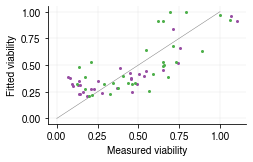

In [34]:
label_dict = {'wt': "Parental", 'pi3k': "PI3K$^{H1047R}$"}
fig, ax = plt.subplots(figsize=cm2inch(9.,6))

# Add identity
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="-", c="gray", linewidth=0.5)    

for cl in ['wt', 'pi3k']:
    plt.plot(
        list(viabilities_predictions.loc[cl].NormalizedViability),
        list(viabilities_predictions.loc[cl].PredictedViability),
        marker = '.', color = col_dict[cl], markersize = 4,
        linestyle = '',
        label = label_dict[cl]
    )

#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#adds major gridlines
ax.grid(color='lightgrey', linestyle='-', linewidth=0.25)

# Plot Legend
#ax.legend(ncol = 2, bbox_to_anchor=(1, -0.9))

# Axis labels and title
plt.xlabel("Measured viability")
plt.ylabel("Fitted viability")
plt.tight_layout()
#plt.savefig('../figures/correlations-and-predictions/combined-model-fit.pdf')

What is the standard deviation and the mean of the residuals?

In [49]:
residuals = viabilities_predictions.PredictedViability - viabilities_predictions.NormalizedViability

In [51]:
statistics.mean(list(residuals))

0.006997496214405535

In [52]:
statistics.stdev(list(residuals))

0.17335308291562568